In [1]:
import ee
import geemap
import hvplot.pandas
import hvplot.xarray
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
import holoviews as hv
import matplotlib.pyplot as plt

# Add the 'scripts' folder to the Python path
import sys
import os
sys.path.append(os.path.abspath('scripts'))

# Import custom functions
import constants as c

In [2]:
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


## Load RF-Regressor

In [38]:
asset_name = 'sosw_spm_rfregressor_rrs_14052024'
folder_name = r'projects/ee-soswater/assets/classifiers'
asset_id = folder_name + '/' + asset_name
ee_rf_model = ee.Classifier.load(asset_id)

## Define sampling site

In [175]:
import geopandas as gpd
from shapely import wkt

#wkt_str = 'MultiPolygon (((105.98868591 13.5406822, 105.99085617 13.53431199, 105.98314277 13.53120747, 105.979839 13.53044141, 105.97458614 13.53182569, 105.97077091 13.53253798, 105.97202883 13.53839755, 105.97849814 13.53834379, 105.98314277 13.53894855, 105.98868591 13.5406822)))'
#wkt_str = 'MultiPolygon (((105.97663327 13.53842664, 105.9755172 13.53148996, 105.97224873 13.53207125, 105.96929913 13.53261379, 105.96818307 13.5327688, 105.96611038 13.53253629, 105.96696071 13.53916293, 105.97150469 13.53828455, 105.97525147 13.53834914, 105.97663327 13.53842664)))'
#wkt_str = 'MultiPolygon (((105.96939214 13.53873666, 105.97381653 13.53841372, 105.97234173 13.53196791, 105.96823621 13.53274297, 105.96939214 13.53873666)))'

# Don Sahong downstream
#wkt_str = 'POLYGON ((105.954638 13.942731, 105.954144 13.943689, 105.951934 13.943585, 105.951891 13.942043, 105.95232 13.940523, 105.952749 13.93919, 105.95247 13.937545, 105.955625 13.937149, 105.955217 13.938899, 105.954573 13.939774, 105.954294 13.940607, 105.954337 13.941502, 105.954638 13.942731))'
# Don Sahong upstream
wkt_str = 'POLYGON ((105.966589 13.95002, 105.967662 13.950144, 105.967791 13.948978, 105.967534 13.9475, 105.965581 13.945584, 105.962899 13.944355, 105.958178 13.94371, 105.956719 13.94371, 105.956419 13.944667, 105.958886 13.944959, 105.960796 13.945292, 105.963671 13.94625, 105.965345 13.9475, 105.966117 13.948166, 105.966589 13.95002))'

# Sesan dam downstream
wkt_str = 'POLYGON ((106.199255 13.576164, 106.198826 13.573828, 106.203246 13.573661, 106.205006 13.573369, 106.208782 13.572827, 106.212559 13.573327, 106.217237 13.574037, 106.220798 13.573745, 106.226592 13.571867, 106.231613 13.569907, 106.233501 13.571909, 106.228695 13.574746, 106.223931 13.576164, 106.221099 13.57729, 106.218309 13.577332, 106.212344 13.576248, 106.209211 13.575622, 106.206036 13.575664, 106.199255 13.576164))'

df = pd.DataFrame({
    'station_id': ['SKB'],
    'WKT': [wkt_str]
})
df['geometry'] = df.WKT.apply(wkt.loads)
df.drop('WKT', axis=1, inplace=True)
gdf_station = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# Plot
gdf_station.hvplot(geo=True, tiles='OSM', color='yellow', alpha=0.5, label='Sampling geometry')

:Overlay
   .WMTS.I                     :WMTS   [Longitude,Latitude]
   .Polygons.Sampling_geometry :Polygons   [Longitude,Latitude]

## Prepare imagery and apply model

In [181]:
start_date, end_date = '2000-01-01', '2024-06-07' # timespan to extract
cld_filt_thresh = 70 # scene-based cloud filter
cld_buffer, water_buffer = 250, 30 # cloud (grow) and water (erosion) buffer (meters)
watermask = 'index' # type of watermask to apply
gdrive_folder = r'E:\Google Drive\Earth Engine'
output_folder = 'SOSW_SPM_Rrs_07062024'

In [182]:
%load_ext autoreload
%autoreload 2
import functions_process as funcs_process
import functions_turbidity as funcs_turb
import functions_sampling as funcs_sampling
from tqdm.notebook import tqdm

settings = {
    'start_date':       start_date,
    'end_date':         end_date,
    'cld_buffer':       cld_buffer,
    'water_buffer':     water_buffer,
    'cld_filt_thresh':  cld_filt_thresh,
    'watermask':        watermask,
    'harmonize_bnames': True,
    'add_indices':      True,
    'add_ratios':       True
}

fc_station = ee.FeatureCollection(geemap.gdf_to_ee(gdf_station))
fn = gdf_station.station_id.iloc[0]
bounds = fc_station.geometry()

ic_oli = funcs_process.load_rrs_imcoll(sensor='oli', bounds=bounds, **settings)
fc_oli = ic_oli \
    .map(lambda img: img.classify(ee_rf_model).copyProperties(img) \
        .set('system:time_start', img.get('system:time_start'))) \
    .map(funcs_sampling.get_sample(bounds, buffer_dist=15))

ic_etm = funcs_process.load_rrs_imcoll(sensor='etm', bounds=bounds, **settings)
fc_etm = ic_etm \
    .map(lambda img: img.classify(ee_rf_model).copyProperties(img) \
        .set('system:time_start', img.get('system:time_start'))) \
    .map(funcs_sampling.get_sample(bounds, buffer_dist=15))

ic_msi = funcs_process.load_rrs_imcoll(sensor='msi', bounds=bounds, **settings)
fc_msi = ic_msi \
    .map(lambda img: img.classify(ee_rf_model).copyProperties(img) \
        .set('system:time_start', img.get('system:time_start'))) \
    .map(funcs_sampling.get_sample(bounds, buffer_dist=15))

fc_samples = ee.FeatureCollection([fc_oli, fc_msi, fc_etm]).flatten() \

task = ee.batch.Export.table.toDrive(**{
    'collection': fc_samples, 
    'description': f'Rrs_downstream_sesan_{fn}',
    'folder': output_folder})
task.start()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import GEE data

In [188]:
import ast 

path_output = Path(gdrive_folder).joinpath(output_folder)
paths_csv = list(path_output.glob('*downstream_sesan*.csv'))

df = pd.DataFrame([])
for path in paths_csv:
    try:
        df_temp = pd.read_csv(path)
        df = pd.concat([df, df_temp])
    except pd.errors.EmptyDataError:
        print(f'Note: {path.name} was empty. Skipping.')
        continue # will skip the rest of the block and move to next file

def parse_str_dict(string):
    string = string.replace('=', '":').replace(', ', ', "').replace('null', 'None')[1:-1]
    string = '{"' + string +'}'
    parsed_dict = dict(ast.literal_eval(string))
    return parsed_dict

df['match_values'] = df.match_values.apply(parse_str_dict)
df_match_values = df['match_values'].apply(pd.Series)
df = pd.concat([df.drop('match_values', axis=1), df_match_values], axis=1)
# df.hvplot.scatter(x='add_ratio_rgb_mean', y='spm', c='match_td_days_abs', alpha=0.5, cmap='bwr')

# prep dataframe
df_samples = df.drop(columns=['.geo']).copy()
df_samples = df_samples.loc[~np.isnan(df_samples.classification_mean)]
df_samples.columns = df_samples.columns.str.replace(f'classification', 'spm', regex=True)
df_samples['dt_utc'] = pd.to_datetime(df_samples['dt_utc'], format='mixed')


In [191]:
df.spm_mean.hvplot()

:Curve   [dt_utc]   (spm_mean)

In [193]:
target_label = 'spm_mean'
df = df_samples.set_index('dt_utc').sort_index()
df_before = df.loc['2000-01-01':'2017-12-31'][target_label]
df_before_agg = df_before.groupby(df_before.index.month).mean()
df_after = df.loc['2018-12-18':'2024-12-31'][target_label]
df_after_agg = df_after.groupby(df_after.index.month).mean()

# plot
from bokeh.models import FixedTicker, FuncTickFormatter
xticker = FixedTicker(ticks=list(range(1, 13)))
minorticker = FixedTicker(ticks=[i + 0.5 for i in range(1, 13)])

df_before_agg.hvplot.scatter(color='saddlebrown', label='Before', 
    #width=1000, height=400,
    yticks=[0, 50, 100, 150, 200, 250, 300]) * \
df_before_agg.hvplot(color='saddlebrown', label='Before') * \
df_after_agg.hvplot.scatter(xlabel='', ylabel='SPM (mg/L)', color='olive', label='After') * \
df_after_agg.hvplot(color='olive', label='After') \
    .opts(xformatter=FuncTickFormatter(code="""
    var names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
                 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'};
    return names[tick];
"""),
    xticks=xticker.ticks,
    fontsize={'xticks': '14pt', 'yticks': '14pt', 'xlabel': '16pt', 'ylabel': '16pt'})

:Overlay
   .Scatter.Before :Scatter   [dt_utc]   (spm_mean)
   .Curve.Before   :Curve   [dt_utc]   (spm_mean)
   .Scatter.After  :Scatter   [dt_utc]   (spm_mean)
   .Curve.After    :Curve   [dt_utc]   (spm_mean)

In [194]:
100-df_after_agg.sum()/df_before_agg.sum()*100

47.55451321412654

In [127]:
df.spm_mean.dropna().hvplot()

:Curve   [dt_utc]   (spm_mean)

## Read DSMP sediment data to validate

In [9]:
path_csv = r'E:\git\SOS-Water\WP3\T3.2\notebooks\mrc_webscrapper\outputs\csv\Sediment Flux\SedimentFlux.CalculatedDSMP@KH_SKB_[SekongBridge].csv'
df_dsmp_flux = pd.read_csv(path_csv)
df_dsmp_flux['date'] = pd.to_datetime(df_dsmp_flux['date'])

path_csv = r'E:\git\SOS-Water\WP3\T3.2\notebooks\mrc_webscrapper\outputs\csv\Sediment Concentration\SedimentConcentration.MeasuredDSMP@KH_SKB_[SekongBridge].csv'
df_dsmp_sedi = pd.read_csv(path_csv)
df_dsmp_sedi['date'] = pd.to_datetime(df_dsmp_sedi['date'])

path_csv = r'E:\git\SOS-Water\WP3\T3.2\notebooks\mrc_webscrapper\outputs\csv\Discharge\Discharge.MeasuredDSMP@KH_SKB_[SekongBridge].csv'
df_dsmp_q = pd.read_csv(path_csv)
df_dsmp_q['date'] = pd.to_datetime(df_dsmp_q['date'])

## Read CASCADE data
Read CASCADE file containing discharge (m3/s) measurements at Sekong Bridge.

C:\Users\Michael\AppData\Local\Temp\ipykernel_26264\4195265021.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = x[sorted_indices]
C:\Users\Michael\AppData\Local\Temp\ipykernel_26264\4195265021.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = y[sorted_indices]


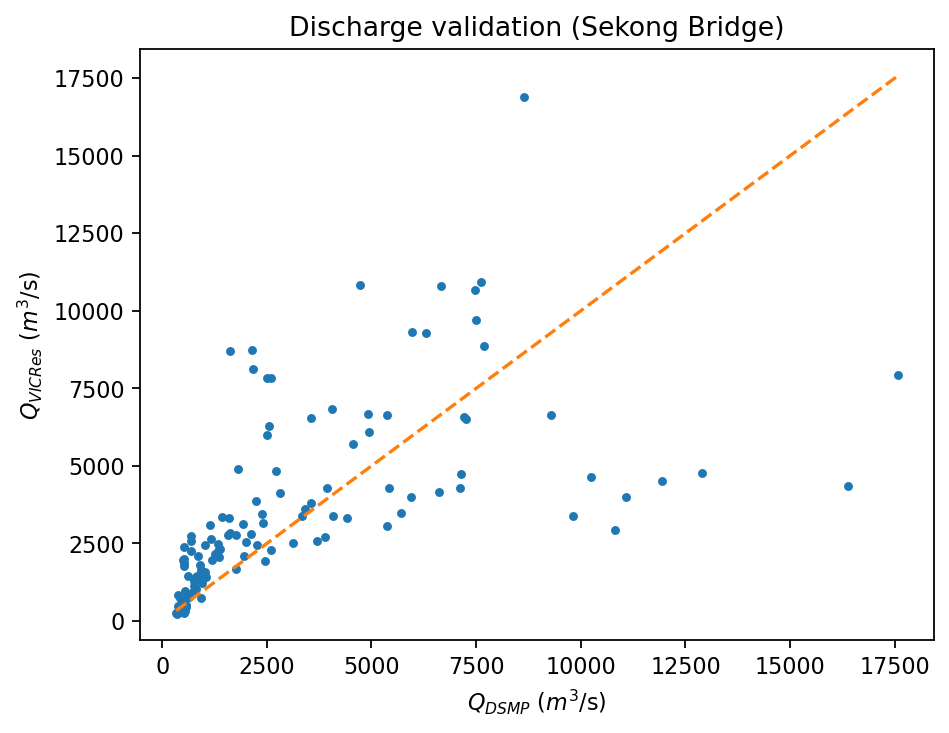

In [10]:
columns = ['year', 'month', 'day', 'discharge']
path_csv = 'data/cascade/SekongBridgeDischarge.day'
df_q = pd.read_csv(path_csv, skiprows=1, delimiter=r'\s+', names=columns)
df_q['date'] = pd.to_datetime(df_q['year'].astype(str) + '-' + 
                            df_q['month'].apply(lambda x: str(x).zfill(2)) + '-' + 
                            df_q['day'].apply(lambda x: str(x).zfill(2)))
df_q = df_q.drop(columns=['year', 'month', 'day'])

# Validate using DSMP
df_cascade_q_daily = df_q.set_index('date').resample('D').mean()
df_dsmp_q_daily = df_dsmp_q.set_index('date')[['value']].resample('D').mean()
df_dsmp_q_daily.index = df_dsmp_q_daily.index.date
df_q_val = pd.merge(df_cascade_q_daily, df_dsmp_q_daily, left_index=True, right_index=True).dropna()

# Plot 
x = df_q_val.value
y = df_q_val.discharge
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
fig, ax=plt.subplots(dpi=160)
plt.plot(x_sorted, y_sorted, '.', label="data", alpha=1)
plt.plot(x_sorted, x_sorted, '--', label="1:1")
plt.xlabel('$Q_{DSMP}$ ($m^{3}$/s)')
plt.ylabel('$Q_{VICRes}$ ($m^{3}$/s)')
plt.title("Discharge validation (Sekong Bridge)")
plt.show()

## Interpolate gaps using sediment rating curves

In [17]:
from sklearn.linear_model import LinearRegression

df_spm_daily = df_samples.set_index('dt_utc').filter(regex='^spm').resample('D').mean()
df_q_daily = df_q.set_index('date').resample('D').mean()
df_est_daily = pd.merge(df_spm_daily, df_q_daily, left_index=True, right_index=True)

x_label = 'discharge'
y_label = 'spm_mean'
apply_log = False

window_size = 365.25*10
half_window = window_size // 2

df_interp_daily = df_est_daily.resample('D').mean()
df = df_interp_daily

# apply interpolation using time-dependent rating curve
for date, row in df.iterrows():
    if (~np.isnan(row[y_label])) | (np.isnan(row[x_label])):
        continue
    window_start = date - pd.Timedelta(days=half_window)
    window_end = date + pd.Timedelta(days=half_window)
    df_temp = df.dropna() #df[(df.index >= window_start) & (df.index <= window_end)].dropna()
    
    if df_temp.shape[0] > 1:
        # Apply linear regression on log-log transform
        X = df_temp[x_label].values.reshape(-1, 1)
        y = df_temp[y_label].values
        if apply_log:
            X, y = np.log(X), np.log(y)
        model = LinearRegression()
        model.fit(X, y)
        if apply_log:
            prediction_log = model.predict(np.log1p([[df.loc[date, x_label]]]))[0]
            prediction = np.expm1(prediction_log)
        else:
            prediction = model.predict([[df.loc[date, x_label]]])[0]
        df.loc[date, y_label] = prediction
df_interp_daily = df

# calculate flux
# conversion q: m^3/s to m^3/day
# conversion spm: mg/L to kg/m^3
df_interp_daily['flux'] = (df_interp_daily[x_label]*24*60*60) * (df_interp_daily[y_label]/1000000)

C:\Users\Michael\AppData\Local\Temp\ipykernel_26264\1076601782.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = x[sorted_indices]
C:\Users\Michael\AppData\Local\Temp\ipykernel_26264\1076601782.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = y[sorted_indices]


Text(0.5, 1.0, 'SPM validation (Sekong Bridge)')

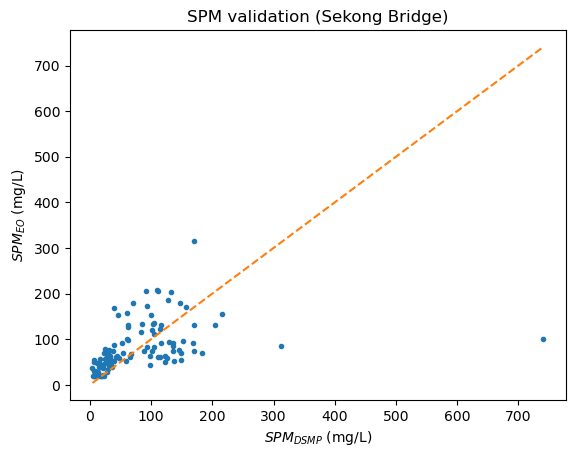

In [18]:
# Validate using DSMP
df_dsmp_sedi_daily = df_dsmp_sedi.set_index('date')[['value']].resample('D').mean()
df_dsmp_sedi_daily.index = df_dsmp_sedi_daily.index.date
df_q_val = pd.merge(df_dsmp_sedi_daily.dropna(), df_interp_daily, left_index=True, right_index=True)

# Plot 
x = df_q_val.value
y = df_q_val[y_label]
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
plt.plot(x_sorted, y_sorted, '.', label="data", alpha=1)
plt.plot(x_sorted, x_sorted, '--', label="1:1")
plt.ylabel('$SPM_{EO}$ (mg/L)')
plt.xlabel('$SPM_{DSMP}$ (mg/L)')
plt.title("SPM validation (Sekong Bridge)")

In [21]:
plot_spm = df_interp_daily.hvplot(y=y_label, label='SPM (q-interpolated)', color='black',
    width=1000, xlabel='', ylabel='SPM (mg/L)', title='SPM validation (Sekong Bridge)') * \
    df_est_daily.hvplot.scatter(y=y_label, label='SPM (EO-model)', color='red', marker='+') * \
    df_dsmp_sedi.hvplot.scatter(x='date', y='value', label='Sediment Concentration (DSMP)', color='green', marker='+') *\
    df_dsmp_sedi.set_index('date')['value'].resample('D').mean().interpolate(limit=14).hvplot(y='value', label='Sediment Concentration (DSMP)', color='green')
    
plot_flux = df_interp_daily.flux.hvplot(label='Flux (q-interpolated)', color='black',
    width=1000, xlabel='', ylabel='Sediment Flux (tonnes/day)', title='Flux validation (Sekong Bridge)') *\
    df_dsmp_flux.hvplot.scatter(x='date', y='value', label='Flux (DSMP)', marker='+', color='green') *\
    df_dsmp_flux.set_index('date')['value'].resample('D').mean().interpolate(limit=14).hvplot(y='value', label='Flux (DSMP)', color='green')

df_q_diff = df_q.set_index('date').discharge - df_dsmp_q.set_index(df_dsmp_q.date.dt.date).value
plot_q_diff = hv.HLine(0).opts(color='black') * \
    df_q_diff.hvplot.scatter(xlabel='', ylabel='Discharge (m³/s)', title='Discharge validation (Sekong Bridge)', width=1000, 
                             label='ΔQ (VICRes - DSMP)', marker='+', color='red') * \
    df_q_diff.resample('D').mean().interpolate(limit=14).hvplot(label='ΔQ (VICRes - DSMP)', color='red')

plot_q = df_q.hvplot(x='date', y='discharge', label='Q (VICRes)', color='black',
    width=1000, xlabel='', ylabel='Discharge (m³/s)', title='Discharge validation (Sekong Bridge)') * \
    df_dsmp_q.hvplot.scatter(x='date', y='value', label='Q (DSMP)', marker='+', color='green') * \
    df_dsmp_q.set_index('date')['value'].resample('D').mean().interpolate(limit=14).hvplot(y='value', label='Q (DSMP)', color='green')

plot_spm = plot_spm.opts(xlim=(pd.Timestamp('2012-01-01'), pd.Timestamp('2019-01-01')))
plot_flux = plot_flux.opts(xlim=(pd.Timestamp('2012-01-01'), pd.Timestamp('2019-01-01')))
plot_q = plot_q.opts(xlim=(pd.Timestamp('2012-01-01'), pd.Timestamp('2019-01-01')))
plot_q_diff = plot_q_diff.opts(xlim=(pd.Timestamp('2012-01-01'), pd.Timestamp('2019-01-01')))

plots = hv.Layout([plot_spm, plot_q, plot_q_diff, plot_flux]).cols(1).opts(shared_axes=False)
plots

:Layout
   .Overlay.I                                                              :Overlay
      .Curve.SPM_left_parenthesis_q_hyphen_minus_interpolated_right_parenthesis :Curve   [index]   (spm_mean)
      .Scatter.SPM_left_parenthesis_EO_hyphen_minus_model_right_parenthesis     :Scatter   [index]   (spm_mean)
      .Scatter.Sediment_Concentration_left_parenthesis_DSMP_right_parenthesis   :Scatter   [date]   (value)
      .Curve.Sediment_Concentration_left_parenthesis_DSMP_right_parenthesis     :Curve   [date]   (value)
   .Overlay.II                                                             :Overlay
      .Curve.Q_left_parenthesis_VICRes_right_parenthesis :Curve   [date]   (discharge)
      .Scatter.Q_left_parenthesis_DSMP_right_parenthesis :Scatter   [date]   (value)
      .Curve.Q_left_parenthesis_DSMP_right_parenthesis   :Curve   [date]   (value)
   .Overlay.ΔQ_left_parenthesis_VICRes_hyphen_minus_DSMP_right_parenthesis :Overlay
      .HLine.I                                                                :HLine   [x,y]
      .Scatter.ΔQ_left_parenthesis_VICRes_hyphen_minus_DSMP_right_parenthesis :Scatter   [date]   (0)
      .Curve.ΔQ_left_parenthesis_VICRes_hyphen_minus_DSMP_right_parenthesis   :Curve   [date]   (0)
   .Overlay.III                                                            :Overlay
      .Curve.Flux_left_parenthesis_q_hyphen_minus_interpolated_right_parenthesis :Curve   [index]   (flux)
      .Scatter.Flux_left_parenthesis_DSMP_right_parenthesis                      :Scatter   [date]   (value)
      .Curve.Flux_left_parenthesis_DSMP_right_parenthesis                        :Curve   [date]   (value)

In [66]:
df_q_diff = df_q.set_index('date').discharge - df_dsmp_q.set_index(df_dsmp_q.date.dt.date).value
plot_q_diff = hv.HLine(0) * \
    df_q_diff.hvplot.scatter(label='Q (difference)', marker='+', color='red') * \
    df_q_diff.resample('D').mean().interpolate(limit=14).hvplot(label='Q (difference)', color='red')
    
plot_q_diff

:Overlay
   .HLine.I                                                 :HLine   [x,y]
   .Scatter.Q_left_parenthesis_difference_right_parenthesis :Scatter   [date]   (0)
   .Curve.Q_left_parenthesis_difference_right_parenthesis   :Curve   [date]   (0)

In [ ]:
plot_q_val = df_q.hvplot(x='date', y='discharge', label='Q (CASCADE)', color='black',
    width=1000, ylabel='Discharge (m^3/s)', title='Discharge validation (Sekong Bridge)') * \
    df_dsmp_q.hvplot.scatter(x='date', y='value', label='Q (DSMP)', marker='+', color='green') * \
    df_dsmp_q.set_index('date')['value'].resample('D').mean().interpolate(limit=14).hvplot(y='value', label='Q (DSMP)', color='green')

In [240]:
# (df_merge_daily['discharge']/df_merge_daily['spm_mean']).hvplot(label='daily_ratio') * \
# (df_merge_daily['discharge']/df_merge_daily['spm_mean']).rolling(pd.Timedelta(365.25, 'days'), center=True).median().hvplot(label='daily_ratio (rolling med)')

:Overlay
   .Curve.Daily_ratio                                                :Curve   [index]   (0)
   .Curve.Daily_ratio_left_parenthesis_rolling_med_right_parenthesis :Curve   [index]   (0)

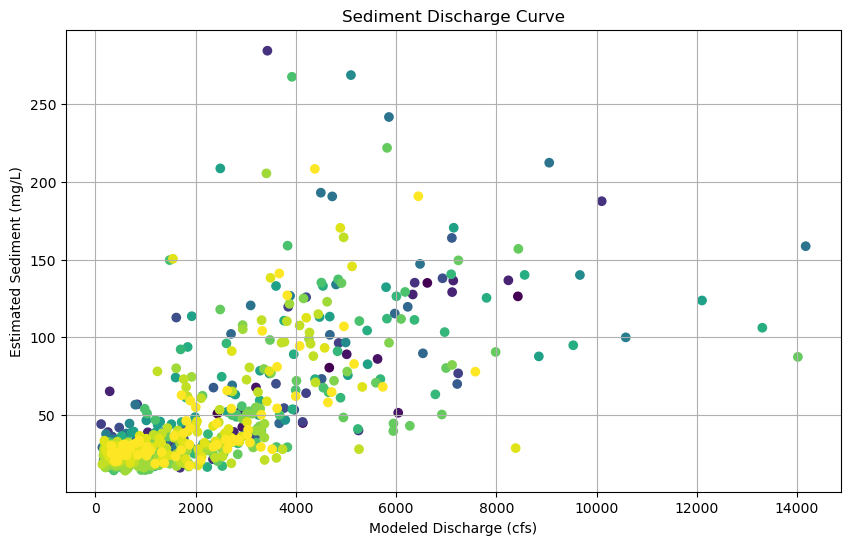

In [398]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_merge_daily['discharge'], df_merge_daily['spm_mean'], c=df_merge_daily['year'])
plt.xlabel('Modeled Discharge (cfs)')
plt.ylabel('Estimated Sediment (mg/L)')
plt.title('Sediment Discharge Curve')
plt.grid(True)
plt.show()